## Text classification with deep learning

In [1]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

# matplotlib
import matplotlib.pyplot as plt

filepath_dict = {'yelp':   '../data/yelp_labelled.txt',
                 'amazon': '../data/amazon_cells_labelled.txt',
                 'imdb':   '../data/imdb_labelled.txt'}

__Helper functions for later__

In [2]:
def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## Load all data into single dataframe

This is maybe not the best practice, especially with larger datasets. But it does allow us to quickly iterate over different datasets!

In [3]:
df_list = []

# for each filepath in the filepath_dict
for source, filepath in filepath_dict.items():
    # read csv
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    # Add another column filled with the source name
    df['source'] = source 
    df_list.append(df)

# concatenate into a single dataframe
df = pd.concat(df_list)
# inspect first entry
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


## Select only amazon reviews (or other subset)

In [4]:
df_yelp = df[df['source'] == 'amazon']

# get the values in each cell; returns a list
sentences = df_yelp['sentence'].values
labels = df_yelp['label'].values

# train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(sentences, 
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Vectorize using ```sklearn```

This is exactly what we have done a whole bunch previously - vecorizing using ```sklearn```.

Here, we're not going to make any special modifications, we're just using default parameters.

In [5]:
vectorizer = CountVectorizer()

We then 'fit' our vectorizer and our data

In [6]:
# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train)
#... then we do it for our test data
X_test_feats = vectorizer.transform(X_test)
# We can also create a list of the feature names. 
feature_names = vectorizer.get_feature_names()

## Logistic regression classifier

Nothing fancy, just a simple baseline.

In [7]:
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

In [8]:
y_pred = classifier.predict(X_test_feats)

## Evaluate

In [9]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

           0       0.74      0.73      0.73        96
           1       0.72      0.73      0.72        91

    accuracy                           0.73       187
   macro avg       0.73      0.73      0.73       187
weighted avg       0.73      0.73      0.73       187



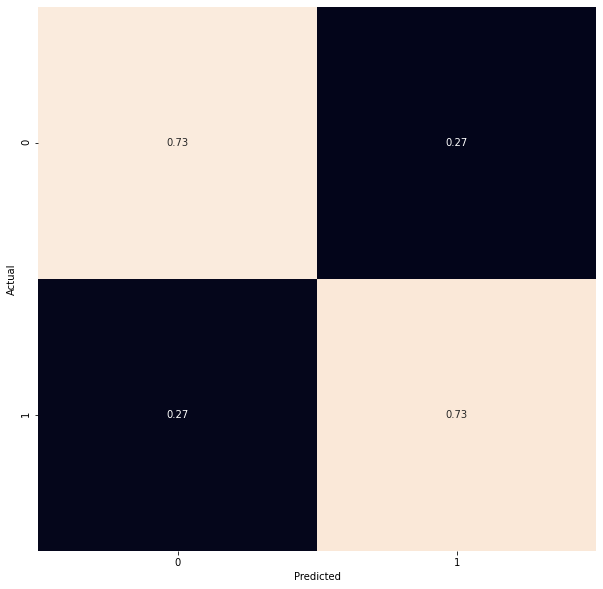

In [10]:
clf.plot_cm(y_test, y_pred, normalized=True)

## Cross validation

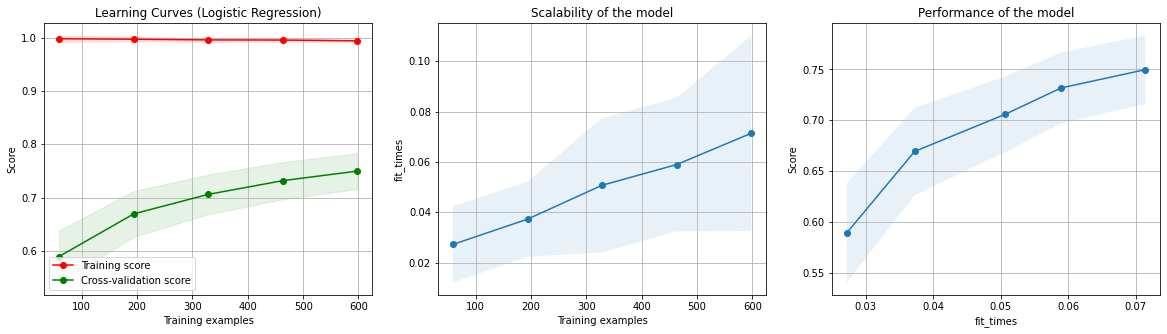

In [11]:
# Vectorize full dataset
X_vect = vectorizer.fit_transform(sentences)

# initialise cross-validation method
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# run on data
model = LogisticRegression(random_state=42)
clf.plot_learning_curve(model, title, X_vect, labels, cv=cv, n_jobs=4)

__Q:__ What do you think of this model? Does it perform well?

## Test on all data sources

Let's quickly iterate over each source of data, to see how well this model performs on different datasets.

In [12]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    X_train1, X_test1, y_train1, y_test1 = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # vectorize
    vectorizer = CountVectorizer()
    # First we do it for our training data...
    X_train_feats1 = vectorizer.fit_transform(X_train1)
    #... then we do it for our test data
    X_test_feats1 = vectorizer.transform(X_test1)

    classifier = LogisticRegression(random_state=42).fit(X_train_feats1, y_train1)
    score = classifier.score(X_test_feats1, y_test1)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Using deep learning

In [13]:
tf.keras.backend.clear_session()

__Simple fully-connected network__

In [14]:
# define architecture 784x256x128x10
input_shape = X_train_feats.shape[0:]

# define architecture input -> 10 -> 1
model = Sequential()
model.add(Dense(10, 
                input_shape=input_shape, 
                activation="relu"))
model.add(Dense(1, activation="sigmoid"))

__Compile model__

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 561, 10)           24260     
_________________________________________________________________
dense_1 (Dense)              (None, 561, 1)            11        
Total params: 24,271
Trainable params: 24,271
Non-trainable params: 0
_________________________________________________________________


Notice that we're using a different optimization algorithm. We've been primarily working with Stochastic Gradient Descent; here we're working with ADAM - you can learn more [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

```tf.keras()``` has a range of optimization algorithms, with slighly different uses. Read more [here](https://keras.io/api/optimizers/).

__Q:__ Rather than calculate loss as categorical_crossentropy, we're using binary_crossentropy. Why might that be?

In [16]:
#plot_model(model, show_shapes=True, show_layer_names=True)

__Train model and evaluate__

In [17]:
history = model.fit(X_train_feats, y_train, 
                    validation_data=(X_test_feats, y_test), 
                    verbose=False, # mute the output, so it doesn't print loads to screen
                    epochs=50,
                    batch_size=10)

In [18]:
loss, accuracy = model.evaluate(X_train_feats, 
                                y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_feats, 
                                y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7647


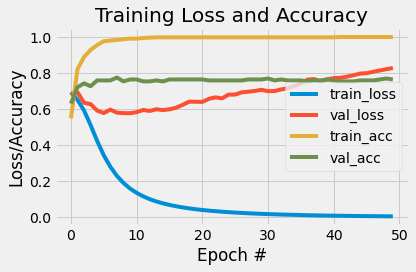

In [19]:
plot_history(history, epochs=50)

## Word embeddings

__Using ```tf.keras.Tokenizer()```__

Using ```tensorflow.keras.Tokenizer()``` allows us to quickly and efficiently convert text to numbers.

In [20]:
# initialize tokenizer
tokenizer = Tokenizer(num_words=5000)
# fit to training data
tokenizer.fit_on_texts(X_train)

# tokenized training and test data
X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

# overall vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# inspect
print(X_train[2])
print(X_train_toks[2])

Every single character was hilarious and deserved to be called a lead.  
[104, 321, 75, 13, 253, 3, 917, 9, 34, 918, 2, 254]


__However!__


Notice how the ```tf.keras``` tokenizer output is different to ```CountVectorizer()```. Why not? How is it different?

__Padding__

To make the Tokenizer output workable, we need to *pad* the documents to be of equal length. 

Compare this to how we pad images when using CNNs on image data.

In [21]:
# max length for a doc
maxlen = 100

# pad training data to maxlen
X_train_pad = pad_sequences(X_train_toks, 
                            padding='post', # sequences can be padded "pre" or "post"
                            maxlen=maxlen)
# pad testing data to maxlen
X_test_pad = pad_sequences(X_test_toks, 
                           padding='post', 
                           maxlen=maxlen)

In [22]:
# inspect
print(X_train[2])
print(X_train_toks[2])
print(X_train_pad[2])

Every single character was hilarious and deserved to be called a lead.  
[104, 321, 75, 13, 253, 3, 917, 9, 34, 918, 2, 254]
[104 321  75  13 253   3 917   9  34 918   2 254   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


__Keras embedding layer__

We now need to convert this numerical representation of the text into a dense, embedded representation.

This can be done quite simply using ```tensorflow.keras```

In [23]:
# define embedding size we want to work with
embedding_dim = 50

# initialize Sequential model
model = Sequential()
# add Embedding layer
model.add(Embedding(input_dim=vocab_size,     # vocab size from Tokenizer()
                    output_dim=embedding_dim, # user defined embedding size
                    input_length=maxlen))     # maxlen of padded docs
# add Flatten layer
model.add(Flatten())
# Add Dense layer; 10 neurons; ReLU activation
model.add(Dense(10, 
                activation='relu'))
# Add prediction node; 1 node with sigmoid; approximates Logistic Regression
model.add(Dense(1, 
                activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           124750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 174,771
Trainable params: 174,771
Non-trainable params: 0
_________________________________________________________________


__Train and evaluate__

In [24]:
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

In [25]:
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.6524


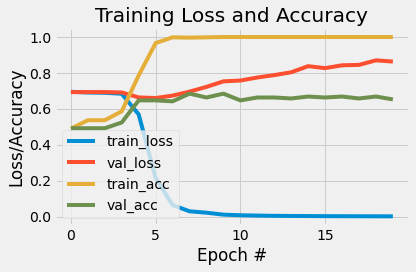

In [26]:
plot_history(history, epochs=20)

__Add MaxPooling layer__

We can decrease the amount of noise and increase the signal in the data by using a MaxPool layer immediately after the Embedding layer.

In [27]:
embedding_dim = 50

# Same as before
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen))

# MaxPool replaces Flatten layer
model.add(GlobalMaxPool1D())

# Same as before
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 125,271
Non-trainable params: 0
_________________________________________________________________


__Train and evaluate__

Training Accuracy: 1.0000
Testing Accuracy:  0.7701


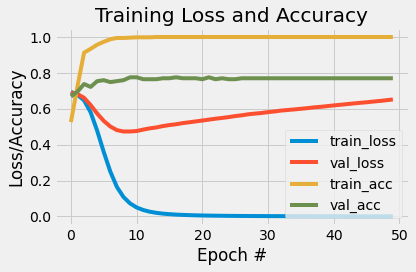

In [28]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# Evaluate
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs=50)

## Use pretrained ```GloVe``` embedding

__Download pretrained embedding__

Jupyter allows you to execute command line functions by using ```!```, to save you time.

In [29]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

__Create embedding matrix__

We map the vocabulary in our data onto the pretrained embeddings, creating an embedding matrix with one row per word in our vocabulary.

In [30]:
embedding_matrix = create_embedding_matrix('../glove/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

__Train model__

In [31]:
# new model
model = Sequential()
# Embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix],  # we've added our pretrained GloVe weights
                    input_length=maxlen, 
                    trainable=False))            # embeddings are static - not trainable

# MaxPool -> FC -> Output
model.add(GlobalMaxPool1D())
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 521
Non-trainable params: 124,750
_________________________________________________________________


Training Accuracy: 0.8111
Testing Accuracy:  0.7112


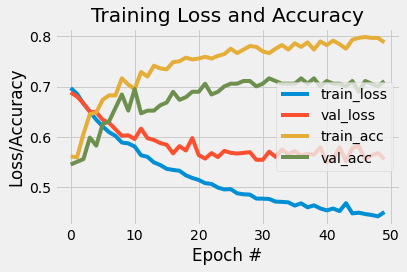

In [32]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)

## Trainable embedding

In [33]:
# new model
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix], # pretrained GloVe weights
                    input_length=maxlen, 
                    trainable=True))            # now we want to train the embeddings, too

# MaxPool -> FC -> Out
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           124750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 125,271
Trainable params: 125,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7701


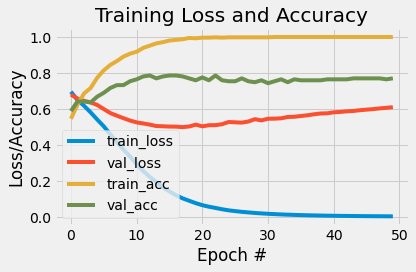

In [34]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)

## From Pooling to Convolutions

We now add additioanl convolutioanl layers, similar to what we do with image data.

In [35]:
embedding_dim = 100

# new model
model = Sequential()

# embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=maxlen))

# CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Conv1D(128, 5, 
                activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

# compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          249500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 314,929
Trainable params: 314,929
Non-trainable params: 0
_________________________________________________________________


__Train and evaluate__

Training Accuracy: 1.0000
Testing Accuracy:  0.7326


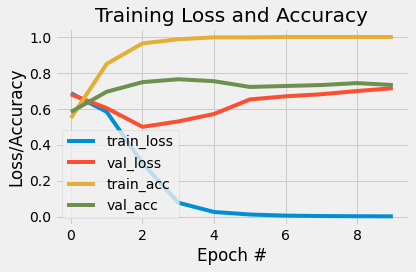

In [36]:
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 10)

## Regularization

In [60]:
l2 = L2(0.0001)

In [61]:
embedding_dim = 50

# New model
model = Sequential()

# Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                    embedding_dim,               # embedding input layer size
                    weights=[embedding_matrix],  # pretrained embeddings
                    input_length=maxlen,         # maxlen of padded doc
                    trainable=True))             # trainable embeddings
model.add(Conv1D(128, 5, 
                activation='relu',
                kernel_regularizer=l2))          # L2 regularization 
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu', kernel_regularizer=l2))
model.add(Dense(1, activation='sigmoid'))

# compile
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           124750    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 158,179
Trainable params: 158,179
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7540


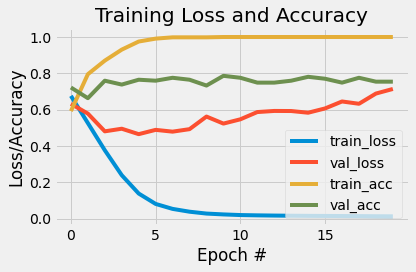

In [62]:
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 20)